In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl")
os.environ['TRAVEl_config_path'] = "/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/config_regen_ego4d.yml"
from travel import init_travel
init_travel()

In [2]:
from travel.constants import CONFIG_PATH, DATA_CACHE_DIR
from travel.data.ego4d import FRAME_KEEP_FREQUENCY
print(CONFIG_PATH, DATA_CACHE_DIR)
print(FRAME_KEEP_FREQUENCY)

/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/config_regen_ego4d.yml /nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_generated_data_0728
0.5


In [48]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


# CaptainCook4D Data

In [27]:
from travel.data.captaincook4d import CaptainCook4DDataset

PARTITION = "val"

# Load mistake detection dataset
dataset = CaptainCook4DDataset(data_split=PARTITION,
                               debug_n_examples_per_class=20)

In [1]:
import matplotlib.pyplot as plt

RETRIEVE_ID = "1_37_0"
RETRIEVE_TIMES = [
                14.0,
                16.0,
                18.0,
                22.0,
                24.0,
                26.0,
                28.0,
                30.0,
                32.0,
                34.0
            ]

# RETRIEVE_ID = "10_46_1"
# RETRIEVE_TIMES = [
#                 0.0,
#                 2.0,
#                 4.0,
#                 6.0,
#                 10.0,
#                 14.0,
#                 16.0,
#                 18.0,
#                 20.0,
#                 22.0,
#                 24.0,
#                 24.516
#             ]

# RETRIEVE_ID = "1_37_2"
# RETRIEVE_TIMES = [
#                 0.0,
#                 6.0,
#                 80.0
#             ]

try:
    retrieve_example = [example for example in dataset if example.example_id == RETRIEVE_ID][0]
except:
    print(f"Could not find CaptainCook4D example {RETRIEVE_ID}.")
    raise

for time in RETRIEVE_TIMES:
    found_frame = False
    for frame, frame_time in zip(retrieve_example.frames, retrieve_example.frame_times):
        if round(frame_time, 1) == round(time, 1):
            found_frame = True
            plt.imshow(frame)
            plt.title(f"Example {retrieve_example.example_id} - Time {round(time,1)}")
            plt.show()
    if not found_frame:
        print(f"Could not find frame at time {time} in example {retrieve_example.example_id}.")

Could not find CaptainCook4D example 1_37_0.


NameError: name 'dataset' is not defined

In [28]:
from travel.constants import MODEL_CACHE_DIR
import os
os.environ['HF_HOME'] = MODEL_CACHE_DIR

from travel.model.vqg import load_vqg_outputs

from transformers import AutoProcessor, AutoModelForVision2Seq, Owlv2Processor, Owlv2ForObjectDetection

vqg_outputs = load_vqg_outputs("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results/vqg/VQG_Llama-2-7b-hf_icl5_20240227131939")

# Load OWL object detector for filtering frames, and filter frames
detector_processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16")
detector = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16", load_in_8bit=True)



The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [29]:
from travel.model.grounding import filter_frames_by_target_objects

dataset = filter_frames_by_target_objects(dataset, detector, detector_processor, vqg_outputs)

filtering frames: 100%|██████████| 40/40 [00:00<00:00, 18676.63it/s]

Filtered out 576 video frames (904 -> 328).


# Ego4D Data

In [4]:
from travel.data.ego4d import Ego4DMistakeDetectionDataset

dataset = Ego4DMistakeDetectionDataset(data_split="val",
                                               mismatch_augmentation=True,
                                               multi_frame=False,
                                      debug_n_examples_per_class=100)

In [5]:
from collections import Counter
from pprint import pprint
mistake_dist = Counter()
for example in dataset:
    mistake_dist[(example.mistake, example.mistake_type)] += 1

pprint(mistake_dist.most_common())

[((False, None), 100),
 ((True, 'MisalignSRL_ARG1'), 37),
 ((True, 'MisalignSRL_V_ARG1'), 32),
 ((True, 'Action Incomplete'), 21),
 ((True, 'MisalignSRL_V'), 10)]


In [6]:
import random

examples_to_visualize = random.sample(list(range(len(dataset))), 20)
# examples_to_visualize = list(range(len(dataset)))


Press a phone with your hand
Success (None)
[2430.0]
(0.0 sec.)
Example ID: 216c7a1a-7ec3-4aa0-a465-e37e7b5fd2f3/78/pos
Verb noun pair: ['press', 'phone_(cellphone,_phone,_smartphone)']
Frame lightness (mean): 0.4481311819172113


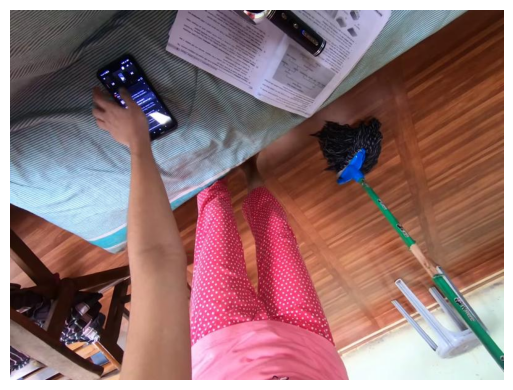


Paint picture
Mistake (MisalignSRL_V_ARG1)
[323.727110955]
(0.0 sec.)
Example ID: a7bffd05-bb79-45cd-8bd1-8c30c5553ddf/9/easyneg_MisalignSRL_V_ARG1_f938bcd9-bf30-4dfb-9a99-d6b9ee53c046_323.7271109546634
Verb noun pair: ['paint', 'paint']
Frame lightness (mean): 0.41502565124444607


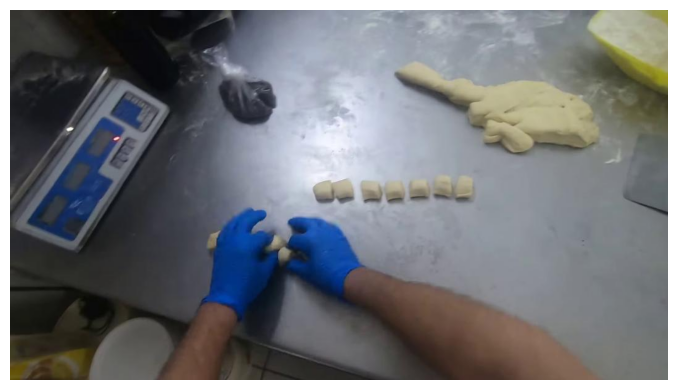


Pull a paper towel on a wall with your hand
Success (None)
[1952.1]
(0.0 sec.)
Example ID: 53da674a-089d-428a-a719-e322b2de002b/63/pos
Verb noun pair: ['pull', 'towel']
Frame lightness (mean): 0.3803670901339481


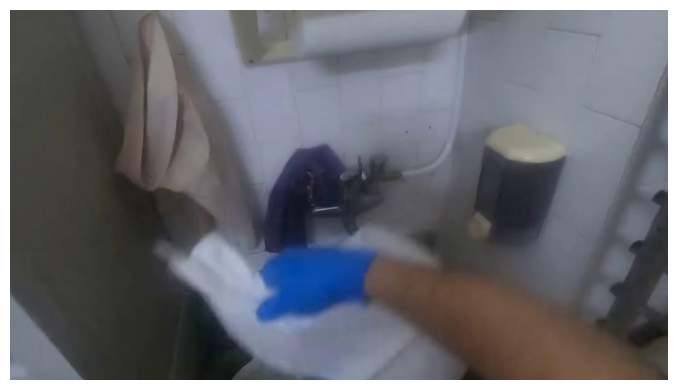


Cut another portion of hay with a sickle
Mistake (MisalignSRL_V_ARG1)
[432.00988]
(0.0 sec.)
Example ID: f5bf2f21-9c7f-4eb1-9573-50e3dc4c84e1/12/easyneg_MisalignSRL_V_ARG1_2d29b45a-169b-453f-8050-98ec147b0ccf_432.00988
Verb noun pair: ['cut_(trim,_slice,_chop)', 'hay']
Frame lightness (mean): 0.32169158224400873


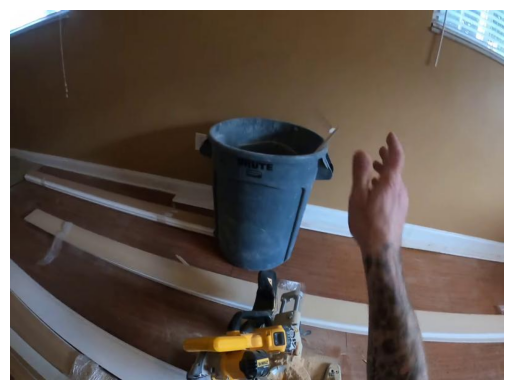


Drop a sieve in the bucket
Mistake (MisalignSRL_ARG1)
[27.9441386]
(0.0 sec.)
Example ID: c864505c-9d49-4da4-bf7e-254b4c348c03/517/easyneg_MisalignSRL_ARG1_980b8448-19df-458e-877a-3dd3e7fa75a5_27.9441386
Verb noun pair: ['put_(place,_leave,_drop)', 'sieve_(sieve,_strainer)']
Frame lightness (mean): 0.48757568355119824


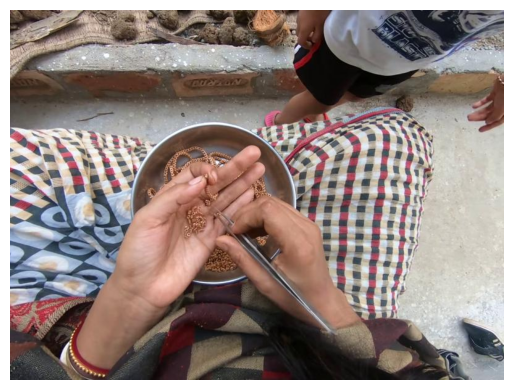


Drop the iron on the table
Mistake (MisalignSRL_V_ARG1)
[999.742580955]
(0.0 sec.)
Example ID: 46af7819-8dfd-4c3c-9b21-5ad0d9095580/73/easyneg_MisalignSRL_V_ARG1_8da5f5a1-ae5f-45e8-a7f7-3226547c3c4d_999.7425809546634
Verb noun pair: ['put_(place,_leave,_drop)', 'iron']
Frame lightness (mean): 0.36773388071895424


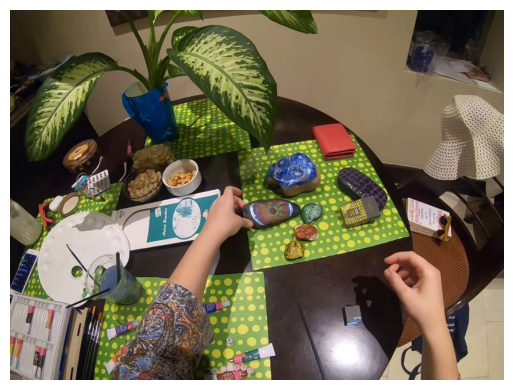


Remove the brush from the wood barricade
Success (None)
[627.8]
(0.0 sec.)
Example ID: b65f4313-9e42-422e-87fe-b7bdb91cd56c/6/pos
Verb noun pair: ['remove', 'paintbrush']
Frame lightness (mean): 0.4485941993464052


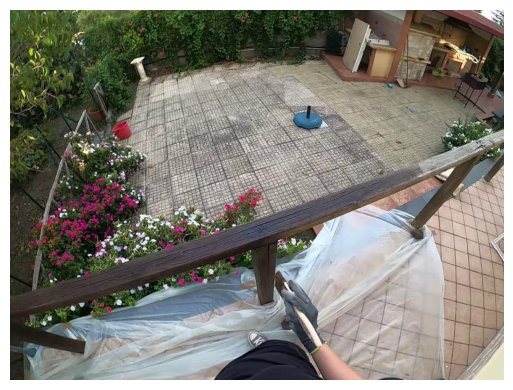


Fold the cloth
Mistake (Action Incomplete)
[701.333333333]
(0.0 sec.)
Example ID: 46af7819-8dfd-4c3c-9b21-5ad0d9095580/43/hardneg
Verb noun pair: ['fold', 'cloth_(cloth,_fabric,_garment,_kanga,_rag)']
Frame lightness (mean): 0.3547674183006536


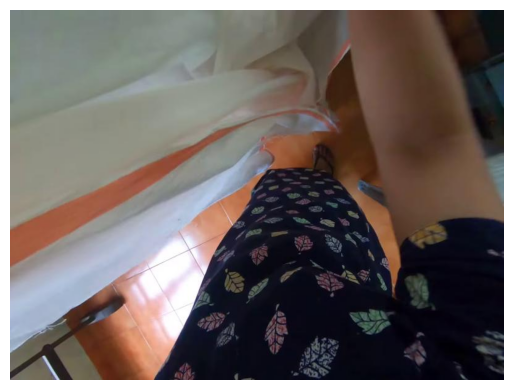


Drop the concrete in your hand   in the iron brick mold
Mistake (MisalignSRL_ARG1)
[282.7938386]
(0.0 sec.)
Example ID: 7e70088e-9874-4116-880e-496c835d71c6/200/easyneg_MisalignSRL_ARG1_3211e658-8467-4539-a67d-c7226767c989_282.7938386
Verb noun pair: ['put_(place,_leave,_drop)', 'cement_(cement,_concrete,_mortar)']
Frame lightness (mean): 0.2906046759259259


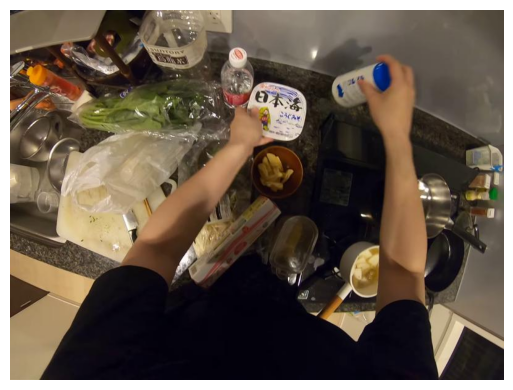


Place the brick on the ground from the mould
Success (None)
[112.533333333]
(0.0 sec.)
Example ID: 91c006d8-b55c-4426-a7b6-dd527a8ec27d/7/pos
Verb noun pair: ['put_(place,_leave,_drop)', 'brick']
Frame lightness (mean): 0.16584328703703702


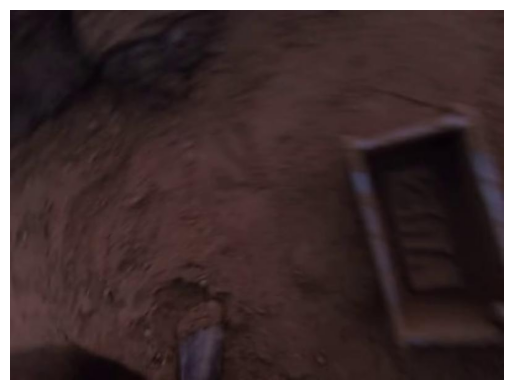


Pack the cards from the table
Mistake (MisalignSRL_V_ARG1)
[5402.969048267]
(0.0 sec.)
Example ID: c7d5d40f-840c-4be0-b79d-ab41394479a2/62/easyneg_MisalignSRL_V_ARG1_1e5bd816-e1dd-43d3-8709-42c83114dc7c_5402.9690482666665
Verb noun pair: ['pack', 'playing_cards']
Frame lightness (mean): 0.20424163943355123


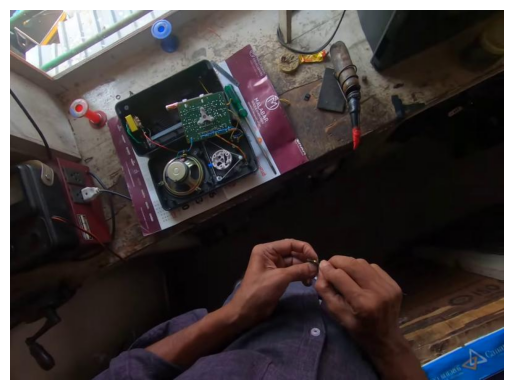


Pick another pack from the floor with your hand
Mistake (MisalignSRL_ARG1)
[397.39775]
(0.0 sec.)
Example ID: 18a3840b-7463-43c4-9aa9-b1d8e486fa84/301/easyneg_MisalignSRL_ARG1_114c1877-5b5b-4ca3-9399-bd535d55669a_397.39775
Verb noun pair: ['take_(pick,_grab,_get)', 'container_(box,_can,_carton,_case,_casing,_container,_crate,_holder,_jar,_jerrycan,_keg,_pack,_package,_packaging,_packet,_storage,_tank,_tin)']
Frame lightness (mean): 0.4238527968409586


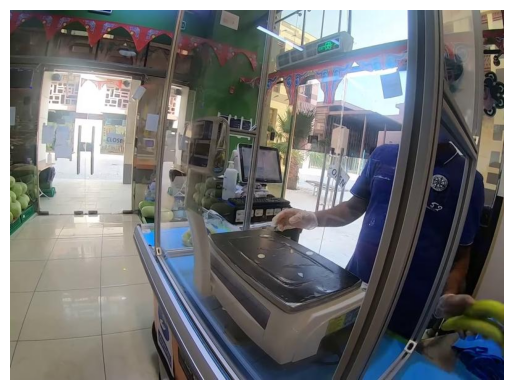


Release the big bag
Success (None)
[514.633333333]
(0.0 sec.)
Example ID: 33943819-f567-4dca-b0ac-ebee2f5e6862/10/pos
Verb noun pair: ['put_(place,_leave,_drop)', 'bag_(bag,_grocery,_nylon,_polythene,_pouch,_sachet,_sack,_suitcase)']
Frame lightness (mean): 0.5426894144880174


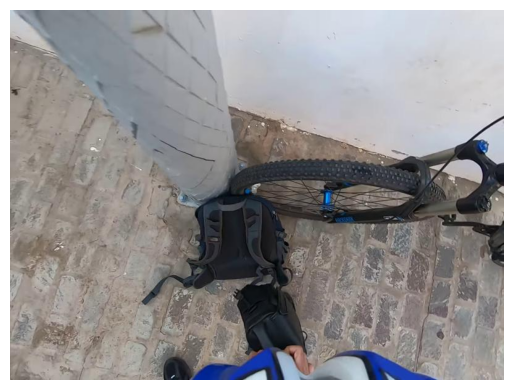


Pick the box in the carton box
Mistake (MisalignSRL_V_ARG1)
[4746.963695267]
(0.0 sec.)
Example ID: 19085a13-c91f-4a45-91ea-889ed9a2727f/213/easyneg_MisalignSRL_V_ARG1_79c62f24-488e-4a69-8220-3b20cb4bf72b_4746.963695266667
Verb noun pair: ['take_(pick,_grab,_get)', 'container_(box,_can,_carton,_case,_casing,_container,_crate,_holder,_jar,_jerrycan,_keg,_pack,_package,_packaging,_packet,_storage,_tank,_tin)']
Frame lightness (mean): 0.3999554302832244


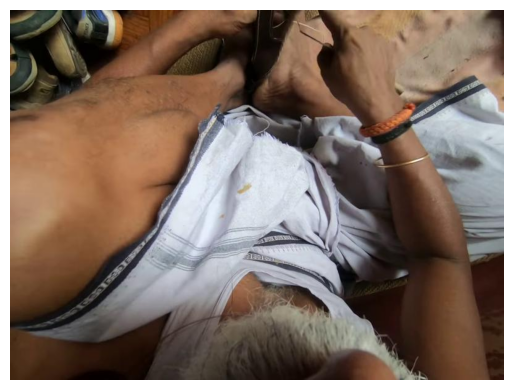


Pick up a mobile phone from another shelf with your hand
Success (None)
[201.8]
(0.0 sec.)
Example ID: 83af5740-e2a0-44e2-a504-d24cdedec4cd/75/pos
Verb noun pair: ['take_(pick,_grab,_get)', 'phone_(cellphone,_phone,_smartphone)']
Frame lightness (mean): 0.4158451906318083


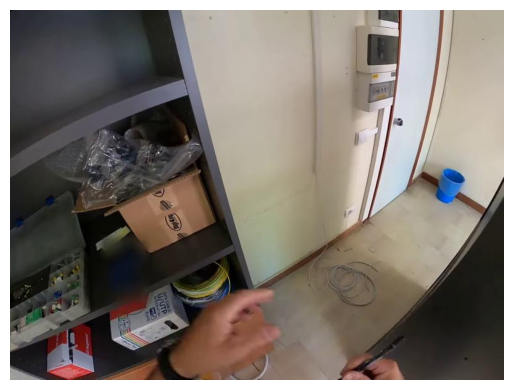


Open   the jerrycan top
Mistake (Action Incomplete)
[43.7]
(0.0 sec.)
Example ID: c864505c-9d49-4da4-bf7e-254b4c348c03/7/hardneg
Verb noun pair: ['open', 'lid_(cap,_cover,_lid)']
Frame lightness (mean): 0.35220336648313694


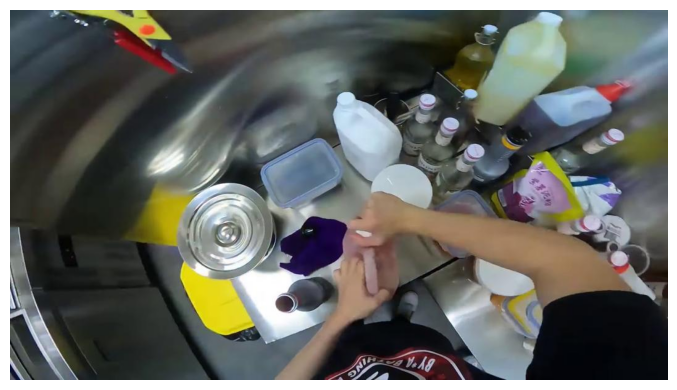


Apply the nail polish on the nail using a nail polish brush
Success (None)
[1563.266666667]
(0.0 sec.)
Example ID: 2dbdd409-0be0-447c-8ae8-3f107fe9af80/281/pos
Verb noun pair: ['apply_(spread,_smear)', 'nail_polish']
Frame lightness (mean): 0.386533419580048


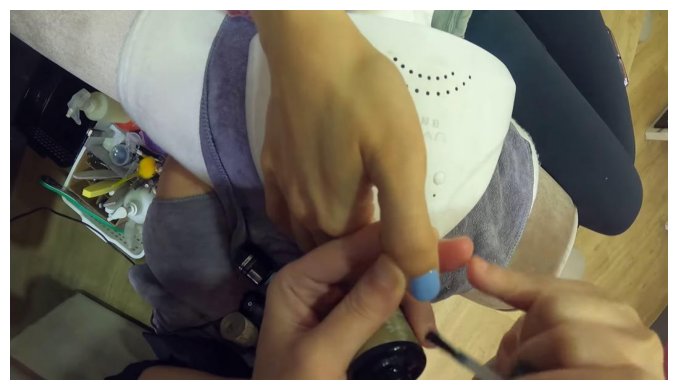


Spray the water from the garden hose around the garden
Success (None)
[477.2]
(0.0 sec.)
Example ID: 281a7f2e-74e0-45b8-b0ca-6f03b58ac6d9/102/pos
Verb noun pair: ['spray', 'flower']
Frame lightness (mean): 0.3402788888888889


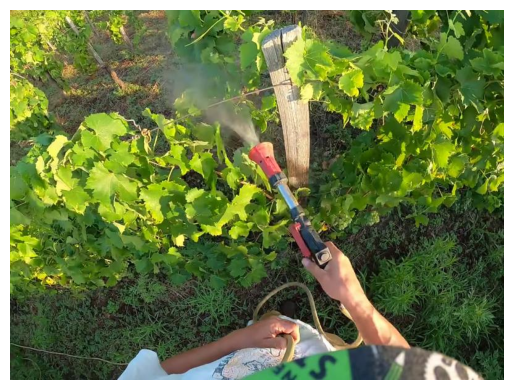


Open the fuel tank of the pumping machine with your hand
Mistake (MisalignSRL_V_ARG1)
[5017.896775267]
(0.0 sec.)
Example ID: 281a7f2e-74e0-45b8-b0ca-6f03b58ac6d9/2/easyneg_MisalignSRL_V_ARG1_3d3efb83-4b41-41e3-94db-50f0f22e67ef_5017.896775266667
Verb noun pair: ['open', 'container_(box,_can,_carton,_case,_casing,_container,_crate,_holder,_jar,_jerrycan,_keg,_pack,_package,_packaging,_packet,_storage,_tank,_tin)']
Frame lightness (mean): 0.47480370098039215


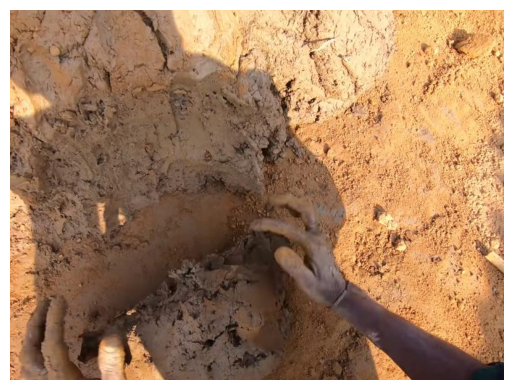


Turn off the garden hose
Mistake (MisalignSRL_ARG1)
[212.8520286]
(0.0 sec.)
Example ID: 281a7f2e-74e0-45b8-b0ca-6f03b58ac6d9/91/easyneg_MisalignSRL_ARG1_8f847cfc-ae36-461c-a96b-8fc58766fb2d_212.8520286
Verb noun pair: ['turn_off_(turn_off,_switch_off)', 'hose']
Frame lightness (mean): 0.4200964705882353


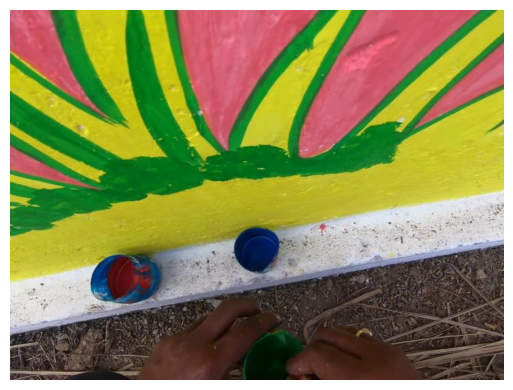

In [7]:
import matplotlib.pyplot as plt
import numpy as np

for example_idx in examples_to_visualize:
    
    example = dataset[example_idx]
    
    print("")
    print(example.procedure_description)
    print(f"{'Success' if not example.mistake else 'Mistake'} ({example.mistake_type})")
    duration = example.frame_times[-1] - example.frame_times[0]
    print(example.frame_times)
    print(f"({duration} sec.)")
    print(f"Example ID: {example.example_id}")
    print("Verb noun pair:", example.verb_noun_pair)
    
    frame_lightnesses = [np.mean(np.asarray(frame)) / 255.0 for frame in example.frames]
    print("Frame lightness (mean):", np.mean(frame_lightnesses))

    fig, axarr = plt.subplots(1, len(example.frames), figsize=(22, 4))

    # Ensure axarr is always iterable
    if len(example.frames) == 1:
        axarr = [axarr]

    for frame, ax in zip(example.frames, axarr):
        if frame is not None:
            ax.imshow(frame)
            ax.axis('off')  # Hide the axes for better visualization

    plt.tight_layout()
    plt.show()


    

# VQG Training Data from Ego4D

In [2]:
from matplotlib import pyplot as plt
import os
import pickle
from pprint import pprint

RESULTS_DIR = "coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results/vqg_learning/VQG_data_debug_Llama-2-7b-hf_icl5_20240429110645"
data_path = os.path.join(RESULTS_DIR, "frameVQA_examples.pkl")
data = pickle.load(open(data_path, "rb"))

print(f"{len(data)} examples generated")
for example in data[100:120]:
    # pprint(example)

    for question_set in example.candidate_question_sets:
        fig, ax = plt.subplots(figsize=(8, 10))

        # Display the image
        ax.imshow(example.frame)

        # Adding text on the image at different positions
        text_offset = 30  # Pixel offset for text below the image
        ax.text(0, example.frame.height + 35, question_set.procedure_description, fontsize=9, style='italic')
        ax.text(0, example.frame.height + 70, f"{question_set.questions[0]} ({question_set.answers[0].name})", fontsize=9)
        ax.text(0, example.frame.height + 105, f"{question_set.questions[1]} ({question_set.answers[1].name})", fontsize=9)

        # Set the limits of the axes and hide them
        ax.set_xlim([0, example.frame.width])
        ax.set_ylim([example.frame.height + text_offset + 50, -10])  # Expanded to fit the text below the image
        ax.axis('off')

        # Display the figure
        plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results/vqg_learning/VQG_data_debug_Llama-2-7b-hf_icl5_20240429110645/frameVQA_examples.pkl'